## **Градиентный бустинг (GBM)**
На сегодняшний день градиентный бустинг (gradient boosting machine) является одним из основных production-решений при работе с табличными, неоднородными данными, поскольку обладает высокой производительностью и точностью, а если быть точнее, то его модификации, речь о которых пойдёт чуть позже.

Как и в случае с Adaboost, градиентый бустинг добавляет базовые модели в ансамбль последовательно, однако вместо обучения моделей с учётом весов на основе ошибок предшественников, в данном случае модели обучаются на остаточных ошибках (residual errors), допущенных предыдущими моделями.


### **Принцип работы градиентного бустинга для регрессии**
Алгоритм строится следующим образом:
- 1) первоначальному прогнозу присваивается среднее значение y_train для всех образцов;
- 2) рассчитываются остатки модели на основе антиградиента функции потерь;
- 3) регрессионное дерево обучается на X_train и остатках, далее делается прогноз на X_train;
- 4) полученный прогноз добавляется к первоначальному и шаги 2-4 повторяются для каждого дерева;
- 5) после обучения всех моделей снова создаётся первоначальный прогноз из шага 1;
- 6) далее делаются прогнозы для X_test на обученных деревьях и добавляются к первоначальному;
- 7) полученная сумма и будет конечным прогнозом.

**Формулы для расчётов**

$L(y_i, F(x_i)) = \frac{1}{2} (y_i - F(x_i))^2 \ - \ $ loss function

$r_{ik} = -\left[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right]_
{F(x) = F_{m-1}(x)} = y_{i} - F_{m-1}(x_i) \ - \ $ residuals

### **Принцип работы градиентного бустинга для классификации**
В случае классификации дела обстоят немного сложнее: к каждому уникальному классу необходимо применить one-hot encoding и перевести в вероятности с помощью softmax-функции, а к прогнозам деревьев добавить коэффициент $\gamma$, который регулирует степень вклада каждого нового дерева в общую модель для снижения переобучения. Также качество прогнозов градиентного бустинга можно существенно улучшить, применив концепцию K-class LogitBoost: для каждого дерева рассчитываются веса, а только потом на их основе остатки.

Алгоритм строится следующим образом:
- 1) для y_train применяется one-hot encoding и первоначальному прогнозу приcваиваются значения 0 для каждого класса;
- 2) прогнозы преобразуются в вероятности с помощью softmax-функции;
- 3) рассчитываются остатки модели на основе антиградиента функции потерь и вероятностей (а также веса в случае LogitBoost);
- 4) регрессионное дерево обучается на X_train и остатках (а в случае LogitBoost ещё присваиваются веса), далее делается прогноз на X_train;
- 5) для каждого листа в дереве рассчитываются коэффициенты $\gamma$ на основе остатков, взятых по позициям наблюдений, попавших в определённый в листовой узел;
- 6) полученные прогнозы для каждого класса и сумма коэффициентов $\gamma$ добавляются к первоначальным;
- 7) шаги 2-6 повторяются для каждого дерева в каждом классе;
- 8) после обучения всех моделей создаётся первоначальный прогноз из шага 1;
- 9) далее делаются прогнозы для X_test на обученных деревьях по каждому классу и добавляются к первоначальным;
- 10) классы с максимальной суммой и будут конечным прогнозом.

**Формулы для расчётов**

$L(\{y_k, F_k(x)\}_{1}^{K}) = -\sum\limits_{k=1}^{K} y_k \ log \ p_k(x) \ - \ $ loss function

$p_k(x) = softmax(F_k(x)) = \frac{e^{F_k(x)}}{\sum\limits_{l=1}^{K} e^{F_l(x)}} \ - \ $ probability of each class

$r_{ik} = -\left[\frac{\partial L(\{y_{il}, F_l(x_i)\}_{l=1}^{K})}{\partial F_k(x_i)}\right]_
{\{F_l(x) = F_{l,m-1}(x)\}_{1}^{K}} = y_{ik} - p_{k,m-1}(x_i) \ - \ $ residuals

$\gamma_{jkm} = \frac{K-1}{K} \frac{\sum_{x_i \in R_{jkm}} r_{ik}}
{\sum_{x_i \in R_{jkm}} |r_{ik}| (1 - |r_{ik}|)}$

$w_k(x_i) = p_k(x_i) (1 - p_k(x_i)) \ - \ $ weigts for K-class LogitBoost

$r_{ik} = \frac{K-1}{K} \frac{y_{ik} - p_k(x_i)}{w_k(x_i)} \ - \ $ residuals for K-class LogitBoost

### **Реализация на Python с нуля**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from mlxtend.plotting import plot_decision_regions

In [2]:
class GBMClassifier:
    def __init__(self, logitboost=False, learning_rate=0.1, n_estimators=100,
                 max_depth=3, random_state=0):
        self.logitboost = logitboost
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state

    def _softmax(self, predictions):
        exp = np.exp(predictions)

        return exp / np.sum(exp, axis=1, keepdims=True)

    def _compute_gammas(self, residuals, leaf_indexes, eps=1e-4):
        gammas = []

        for j in np.unique(leaf_indexes):
            x_i = np.where(leaf_indexes == j)
            numerator = np.sum(residuals[x_i])
            norm_residuals_xi = np.linalg.norm(residuals[x_i]) + eps
            denominator = np.sum(norm_residuals_xi * (1 - norm_residuals_xi))
            gamma = (self.K - 1) / self.K * numerator / denominator
            gammas.append(gamma)

        return gammas

    def fit(self, X, y):
        self.K = len(np.unique(y))
        self.trees = {k: [] for k in range(self.K)}
        one_hot_y = pd.get_dummies(y).to_numpy()   # one-hot encoding
        predictions = np.zeros(one_hot_y.shape)

        for _ in range(self.n_estimators):
            probabilities = self._softmax(predictions)

            for k in range(self.K):
                if self.logitboost:   # based on K-class LogitBoost
                    numerator = (one_hot_y.T[k] - probabilities.T[k])
                    denominator = probabilities.T[k] * (1 - probabilities.T[k])
                    residuals = (self.K - 1) / self.K * numerator / denominator
                    weights = denominator
                else:
                    residuals = one_hot_y.T[k] - probabilities.T[k]
                    weights = None

                tree = DecisionTreeRegressor(criterion='friedman_mse', max_depth=self.max_depth,
                                             random_state=self.random_state)
                tree.fit(X, residuals, sample_weight=weights)
                self.trees[k].append(tree)

                leaf_indexes = tree.apply(X)
                gammas = [] if self.logitboost else self._compute_gammas(residuals, leaf_indexes)
                predictions.T[k] += self.learning_rate * tree.predict(X) + np.sum(gammas)

    def predict(self, samples):
        predictions = np.zeros((len(samples), self.K))

        for i in range(self.n_estimators):
            for k in range(self.K):
                predictions.T[k] += self.learning_rate * self.trees[k][i].predict(samples)

        return np.argmax(predictions, axis=1)

In [3]:
class GBMRegressor:
    def __init__(self, learning_rate=0.1, n_estimators=100, max_depth=3, random_state=0):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []

    def fit(self, X, y):
        self.initial_leaf = y.mean()
        predictions = np.zeros(len(y)) + self.initial_leaf

        for _ in range(self.n_estimators):
            residuals = y - predictions
            tree = DecisionTreeRegressor(criterion='friedman_mse', max_depth=self.max_depth,
                                         random_state=self.random_state)
            tree.fit(X, residuals)
            predictions += self.learning_rate * tree.predict(X)
            self.trees.append(tree)

    def predict(self, samples):
        predictions = np.zeros(len(samples)) + self.initial_leaf

        for i in range(self.n_estimators):
            predictions += self.learning_rate * self.trees[i].predict(samples)

        return predictions

In [4]:
def decision_boundary_plot(X, y, X_train, y_train, clf, feature_indexes, title=None):
    feature1_name, feature2_name = X.columns[feature_indexes]
    X_feature_columns = X.values[:, feature_indexes]
    X_train_feature_columns = X_train.values[:, feature_indexes]
    clf.fit(X_train_feature_columns, y_train.values)

    plot_decision_regions(X=X_feature_columns, y=y.values, clf=clf)
    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title(title)

### **Загрузка датасетов**
Для обучения моделей будет использован [Glass Classification](https://www.kaggle.com/datasets/uciml/glass) датасет, где необходимо верно определить тип стекла по его признакам. В случае регрессии используется Diabetes датасет из scikit-learn.  

**Данные ниже будут использоваться в примерах для всех модификаций градиентного бустинга**.

In [5]:
df_path = "/content/drive/MyDrive/glass.csv"
glass_df = pd.read_csv(df_path)
X1, y1 = glass_df.iloc[:, :-1], glass_df.iloc[:, -1]
y1 = pd.Series(LabelEncoder().fit_transform(y1))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=0)
print(glass_df)

          RI     Na    Mg    Al     Si     K    Ca    Ba   Fe  Type
0    1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.0     1
1    1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.00  0.0     1
2    1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.00  0.0     1
3    1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.00  0.0     1
4    1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.00  0.0     1
..       ...    ...   ...   ...    ...   ...   ...   ...  ...   ...
209  1.51623  14.14  0.00  2.88  72.61  0.08  9.18  1.06  0.0     7
210  1.51685  14.92  0.00  1.99  73.06  0.00  8.40  1.59  0.0     7
211  1.52065  14.36  0.00  2.02  73.42  0.00  8.44  1.64  0.0     7
212  1.51651  14.38  0.00  1.94  73.61  0.00  8.48  1.57  0.0     7
213  1.51711  14.23  0.00  2.08  73.36  0.00  8.62  1.67  0.0     7

[214 rows x 10 columns]


In [6]:
X2, y2 = load_diabetes(return_X_y=True, as_frame=True)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=0)
print(X2, y2, sep='\n')

          age       sex       bmi        bp        s1        s2        s3  \
0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2    0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
..        ...       ...       ...       ...       ...       ...       ...   
437  0.041708  0.050680  0.019662  0.059744 -0.005697 -0.002566 -0.028674   
438 -0.005515  0.050680 -0.015906 -0.067642  0.049341  0.079165 -0.028674   
439  0.041708  0.050680 -0.015906  0.017293 -0.037344 -0.013840 -0.024993   
440 -0.045472 -0.044642  0.039062  0.001215  0.016318  0.015283 -0.028674   
441 -0.045472 -0.044642 -0.073030 -0.081413  0.083740  0.027809  0.173816   

           s4        s5        s6  
0   -0.002592  0.019907 -0.017646  
1  

### **Обучение моделей и оценка полученных результатов**  
В случае классификации ручная реализация немного отличается в плане точности от scikit-learn — это связано с тем, что в последней применяется более усложнённый подход для прогнозирования и расчёта остатков, но суть остаётся прежней, и в большинстве случаев работает примерно также как и ручная реализация, особенно в сравнении с LogitBoost модификацией.

В случае регрессии, ошибка в ручной реализации даже немного ниже, чем в scikit-learn — различия незначительны.

Также стоит отметить, что в scikit-learn есть особая версия градиентного бустинга — HistGradientBoosting на основе LightGBM, предназначенная для работы с большими наборами данных, которая отрабатывает гораздо быстрее и чаще лучше, чем классический градиентный бустинг.

Полученные результаты приведены ниже.


**GBMClassifier**

In [7]:
gbc = GBMClassifier(random_state=0)
gbc.fit(X1_train, y1_train)
gbc_pred_res = gbc.predict(X1_test)
gbc_accuracy = accuracy_score(y1_test, gbc_pred_res)
print(f'gbc accuracy: {gbc_accuracy}')
print(gbc_pred_res)

gbc accuracy: 0.6111111111111112
[5 0 1 4 1 1 0 1 1 1 1 0 1 1 1 5 0 1 1 1 5 0 5 5 1 0 5 0 1 0 0 4 1 0 0 0 0
 0 0 5 1 4 1 0 0 1 0 1 0 1 0 3 5 0]


**GBMClassifier with LogitBoost concept**

In [8]:
logit_bc = GBMClassifier(logitboost=True, random_state=0)
logit_bc.fit(X1_train, y1_train)
logit_bc_pred_res = logit_bc.predict(X1_test)
logit_bc_accuracy = accuracy_score(y1_test, logit_bc_pred_res)
print(f'logit_gbc accuracy: {logit_bc_accuracy}')
print(logit_bc_pred_res)

logit_gbc accuracy: 0.6666666666666666
[5 0 1 4 1 1 0 1 1 1 1 0 0 1 1 5 2 1 1 0 3 0 5 1 2 0 5 0 0 1 0 0 1 0 0 0 0
 2 0 5 1 4 1 0 1 1 0 1 0 1 0 1 5 0]


**GradientBoostingClassifier (scikit-learn)**

sk_gbc accuracy: 0.6666666666666666
[5 0 1 4 1 1 0 1 1 1 1 0 1 1 1 5 2 1 2 0 1 0 5 5 0 0 5 0 0 1 0 0 1 0 1 0 0
 0 0 5 1 1 1 0 1 1 0 1 0 1 0 1 5 0]


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


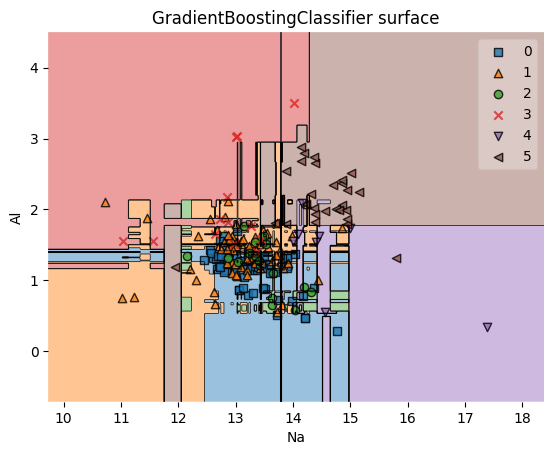

In [9]:
sk_gbc = GradientBoostingClassifier(random_state=0)
sk_gbc.fit(X1_train, y1_train)
sk_gbc_pred_res = sk_gbc.predict(X1_test)
sk_gbc_accuracy = accuracy_score(y1_test, sk_gbc_pred_res)
print(f'sk_gbc accuracy: {sk_gbc_accuracy}')
print(sk_gbc_pred_res)

feature_indexes = [1, 3]
title1 = 'GradientBoostingClassifier surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, sk_gbc, feature_indexes, title1)

**HistGradientBoostingClassifier (scikit-learn)**

sk_hist_gbc accuracy: 0.7407407407407407
[5 0 1 4 1 1 0 1 1 1 0 1 0 1 1 5 2 1 0 2 3 0 5 5 0 0 5 0 1 1 0 0 1 0 0 0 0
 2 0 5 1 4 1 0 0 1 0 1 0 1 0 1 5 0]


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


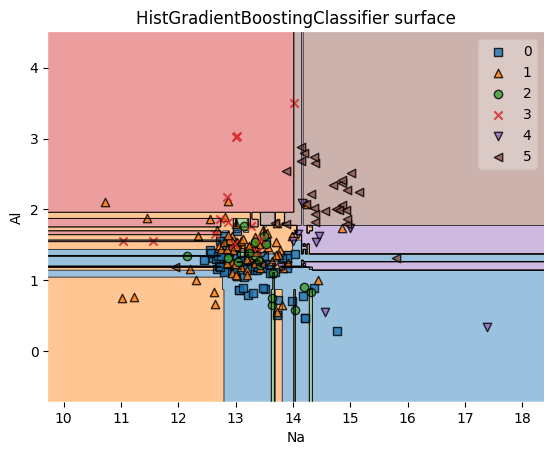

In [10]:
sk_hist_gbc = HistGradientBoostingClassifier(random_state=0)
sk_hist_gbc.fit(X1_train, y1_train)
sk_hist_gbc_pred_res = sk_hist_gbc.predict(X1_test)
sk_hist_gbc_accuracy = accuracy_score(y1_test, sk_hist_gbc_pred_res)
print(f'sk_hist_gbc accuracy: {sk_hist_gbc_accuracy}')
print(sk_hist_gbc_pred_res)

feature_indexes = [1, 3]
title2 = 'HistGradientBoostingClassifier surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, sk_hist_gbc, feature_indexes, title2)

**GBMRegressor**

In [11]:
gbr = GBMRegressor(random_state=0)
gbr.fit(X2_train, y2_train)
gbr_pred_res = gbr.predict(X2_test)
mape = mean_absolute_percentage_error(y2_test, gbr_pred_res)
print(f'gbr mape: {mape}')
print(gbr_pred_res)

gbr mape: 0.399913339601999
[255.26058697 236.87383554 189.22369747 111.4291292  195.31958776
 249.2293251   97.46956406 205.91110801 133.47952304 240.88679883
 187.19018483 171.09963906 132.63933991  86.28964353 286.56077589
 105.78347251 161.94686043  72.58069452 105.92470096 236.52718059
 178.31146418 127.93036968 164.16563703 147.68681371 229.72747212
 194.16656023 142.44300193  68.79177464 237.21638657 163.36730299
 228.0338107   85.82843049 122.42781509 153.99332065 133.44848601
 159.00754731 151.98981608 147.1238119   88.56372077 200.84785209
 111.32129613 157.60108633 137.94395538 173.39402287 176.29284757
  62.85019316 109.646804   124.14982054  83.45697583 266.40618239
 141.2307366   42.05033124 163.57898214 149.92213387 230.37326368
 226.98842404 176.95426024 128.73302071  94.7641018  180.13853236
 242.31821245 147.52903035 130.45931832  97.32617479 246.70709949
 155.26338705  88.36785447 243.39330218 215.93042351  57.89243255
  87.76236479 138.21222825 101.23449416 140.8052

**GradientBoostingRegressor (scikit-learn)**

In [12]:
sk_gbr = GradientBoostingRegressor(random_state=0)
sk_gbr.fit(X2_train, y2_train)
sk_gbr_pred_res = sk_gbr.predict(X2_test)
sk_mape = mean_absolute_percentage_error(y2_test, sk_gbr_pred_res)
print(f'sk_gbr mape: {sk_mape}')
print(sk_gbr_pred_res)

sk_gbr mape: 0.4010647096251489
[255.26058697 236.87383554 189.22369747 111.4291292  195.31958776
 249.2293251   97.46956406 205.91110801 133.47952304 240.88679883
 187.19018483 171.09963906 132.63933991  86.28964353 286.56077589
 105.78347251 161.94686043  72.58069452 105.92470096 236.52718059
 182.08417504 127.93036968 164.16563703 147.68681371 229.72747212
 194.16656023 142.44300193  68.79177464 237.21638657 163.36730299
 223.14955275  85.82843049 122.42781509 153.99332065 133.44848601
 159.00754731 151.98981608 147.1238119   88.56372077 200.84785209
 117.71059889 157.60108633 137.94395538 173.39402287 176.29284757
  62.85019316 109.646804   124.14982054  83.45697583 266.40618239
 141.2307366   42.05033124 163.57898214 149.92213387 230.37326368
 226.98842404 176.95426024 128.73302071  94.7641018  180.13853236
 242.31821245 147.52903035 131.71442058  97.32617479 246.70709949
 155.26338705  88.36785447 243.39330218 215.93042351  54.04270734
  87.76236479 138.21222825 101.23449416 140.

**HistGradientBoostingRegressor (scikit-learn)**

In [13]:
sk_hist_gbr = HistGradientBoostingRegressor(random_state=0)
sk_hist_gbr.fit(X2_train, y2_train)
sk_hist_gbr_pred_res = sk_hist_gbr.predict(X2_test)
sk_hist_mape = mean_absolute_percentage_error(y2_test, sk_hist_gbr_pred_res)
print(f'sk_hist_gbr mape: {sk_hist_mape}')
print(sk_hist_gbr_pred_res)

sk_hist_gbr mape: 0.39301688868165796
[264.59007545 243.59190524 180.62442773 108.53165744 195.17695513
 258.1710931  112.67894454 239.18006052 144.50027011 244.02461776
 180.19087697 171.2628973  142.6966707   94.26236013 301.44493762
  90.25622203 154.82566511  75.43291346  96.36987316 230.14565012
 196.50928346 134.41863815 167.28719774 118.51218378 209.75431111
 176.46248808 113.40188129  68.47515467 248.57638999 116.15751993
 195.54397416  59.94733366 153.03012884 165.84819847 135.95402508
 133.54279177 190.26058998 153.08963938  86.65214731 185.07312005
 110.00197459 142.99434304 111.32566034 205.63519803 163.76035901
  68.26003406 118.15074567 101.01137587  57.54356002 247.29839792
 140.32714196  41.87878548 149.89720974 189.08931404 251.48016218
 175.76119949 160.38118455 110.76716142 107.00114228 154.75409577
 256.3194536  148.8935956  119.32752592  78.65118163 252.18315433
 122.833807    92.10033912 219.56310647 199.35553751  87.27114699
  78.83529151 114.14943246  86.0743350

### **Преимущества и недостатки градиентного бустинга (GBM)**
Преимущества:
- высокая точность;
- хорошо работает с неоднородными данными;
- лежит в основе других модификаций градиентного бустинга.

Недостатки:
- низкая скорость обучения при работе с большими датасетами;
- отсутствие возможности работы с категориальными признаками;
- возможность переобучения из-за плохой предобработки данных.

Стоит отметить, что вышеперечисленные недостатки были устранены частично либо полностью в модификациях градиентного бустинга, про которые сейчас и пойдёт речь.

### **Дополнительные источники**
Статья «Greedy Function Approximation: A Gradient Boosting Machine», Jerome H. Friedman.

Документация:
- [описание градиентного бустинга](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosted-trees);
- [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html);
- [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html);
- [HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html);
- [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html).

Лекции:
- [один](https://www.youtube.com/watch?v=-b6Y1DDxvL4&t=3271s&ab_channel=ComputerScienceCenter);
- [два](https://www.youtube.com/watch?v=V_-BSY7hLC0&list=PLgaemU2xZlTgJhfBHnolmS-8WwsFifnFn&index=11&ab_channel=meanxai);
- [три](https://www.youtube.com/watch?v=wPqtzj5VZus&ab_channel=H2O.ai).

Пошаговое построение Gradient Boosting:
- [один](https://www.youtube.com/watch?v=3CC4N4z3GJc&ab_channel=StatQuestwithJoshStarmer);
- [два](https://www.youtube.com/watch?v=2xudPOBz-vs&t=981s&ab_channel=StatQuestwithJoshStarmer);
- [три](https://www.youtube.com/watch?v=jxuNLH5dXCs&t=2s&ab_channel=StatQuestwithJoshStarmer);
- [четыре](https://www.youtube.com/watch?v=StWY5QWMXCw&t=1942s&ab_channel=StatQuestwithJoshStarmer).

## **Особенности XGBoost**
XGBoost (Extreme Gradient Boosting) является, пожалуй, самой популярной модификацией градиентного бустинга на сегодняшний день, с помощью которой было выиграно множество соревнований на Kaggle. Рассмотрим причины по которым так произошло.

В отличие от GBM в XGboost изначальный прогноз регрессионного дерева устанавливается $f_0 (x) = 0.5$ и вместо пней с глубиной 3 берутся более глубокие деревья с листьями в диапазоне от 8 до 32 как в случае регрессии, так и классификации, а к функции потерь добавляется регуляризация (L1 или L2 на выбор), которая штрафует дерево с высокой суммой нормы значений в листьях. Данная сумма представлена в виде целевой функции, расчёт значений которой аппроксимируется разложением в ряд Тейлора 2-го порядка.

$Obj^{\ t} = \sum\limits_{i=1}^{N} L(y_i, \hat{y_i}^{(t-1)} + f_t(x_i)) + \Omega(f_t) \ - \ $ objective function

$\Omega(f_t) = \gamma \ T + \frac{1}{2} \lambda||w||^2 \ - \ $ L2-regularization

$Obj^{\ t} \approx \sum\limits_{i=1}^{N} [L(y_i, \hat{y_i}^{(t-1)}) + g_i f_t(x_i) +
\frac{1}{2} h_i f_t^2(x_i) ] + \gamma \ T + \frac{1}{2} \lambda \sum\limits_{j=1}^{T} w_j^2 = $ \\
$\ \ \ \ \ \ \ \
= \sum\limits_{j=1}^{T} [(\sum\limits_{i \in I_j}g_i) w_j + \frac{1}{2} (\sum\limits_{i \in I_j}h_i + \lambda) w_j^2 ] + \gamma \ T \ - \ $ second-order Taylor approximation of objective function \\

$g_i \ - \ $ first order gradient

$h_i \ - \ $ second order gradient (hessian)

$ \gamma, \lambda \ - \ $ regularization parameters

Приближение второго порядка удобно с вычислительной точки зрения, поскольку большинство членов одинаковы на каждой отдельной итерации и большая часть выражения может быть вычислена один раз и повторно использована как константа для всех остальных разбиений, и в таком случае единственное, что остаётся вычислить — это  $f_t(x_i)$ и $\Omega(f_t)$.

Оптимальное значение веса j-го листового узла в дереве рассчитывается следующим образом:

$$w^*_j = -\frac{\sum_{i \in I_j} g_i}{\sum_{i \in I_j} h_i + \lambda}$$

Мера загрязнённости представляет из себя качество структуры дерева q и рассчитывается следующим образом:

$$Obj^{\ t} = -\frac{1}{2} \sum\limits_{j=1}^{T} \frac{(\sum_{i \in I_j} g_i)^2}{\sum_{i \in I_j} h_i + \lambda} + \gamma \ T$$

Чем меньше это значение, тем лучше структура дерева.

Поскольку перечисление всевозможных древовидных структур и выбор наилучшей весьма осложнён, мы можем оптимизировать данную задачу, добавляя по одному разбиению узла дерева за раз. В частности, мы итеративно добавляем ветви к дереву, используя жадный алгоритм, а информационный прирост будет выглядеть следующим образом:

$$gain = \frac{1}{2} \left[\frac{(\sum_{i \in I_L} g_i)^2}{\sum_{i \in I_L} h_i + \lambda} + \frac{(\sum_{i \in I_R} g_i)^2}{\sum_{i \in I_R} h_i + \lambda} -
\frac{(\sum_{i \in I} g_i)^2}{\sum_{i \in I} h_i + \lambda} \right] - \gamma $$

Информационный прирост будет показывать изменение чистоты узла после его разбиения. Его максимальное значение будет соответствовать наилучшему пороговому значению (критерию разбиения) узла в дереве.

Стоит также упомянуть, что в XGBoost поддерживается выбор линейных моделей в качестве базовых, но, в целом, они работают хуже деревьев.

### **Дополнительные оптимизации в XGBoost**

**Weighted quantile sketch**

В случае работы с большими наборами данных в XGBoost используется
приближённый жадный алгоритм. Это означает, что вместо тестирования всех возможных пороговых значений мы тестируем только квантили. Используя распараллеливание для разделения набора данных и создания ветвей в каждом дереве независимо друг от друга чтобы несколько ядер могли работать с ними одновременно, алгоритм взвешенных квантилей (weighted quantile sketch) объединяет данные в приближённую гистограмму, разделённую на взвешенные квантили, которые помещают наблюдения с прогнозами низкой достоверности в квантили с меньшим количеством наблюдений.

**Cache-aware access & out-of-core computing**

Для более быстрого вычисления прогнозов градиенты и гессианы хранятся в кэш-памяти (cache-aware access), а в случае с датасетами большого размера, когда недостаточно кэш и оперативной памяти, задействуется память из жёсткого диска. Учитывая, что чтение данных на жёстком диске выполняется гораздо медленнее чем в кэш-памяти, для ускоренной обработки производится их компрессия. Данные хранятся в единицах памяти, называемых блоками, информация в которых хранится в формате сжатых столбцов, отсортированных по соответствующим значениям параллельно с использованием всех доступных ядер ЦП, а распаковка каждого блока осуществляется в независимом потоке при загрузке в память. Данная техника называется "вычисление вне ядра" (out-of-core computing). При наличии нескольких жёстких дисков, применяется параллельное сегментирование блоков для каждого жёсткого диска (sharding).

При использовании сжатых данных необходимо учитывать, что процесс сжатия и распаковки занимает дополнительное время, поэтому выбор алгоритма сжатия (с потерями и без) и его параметров может повлиять на производительность в целом, однако это всё равно значительно быстрее чтения без сжатия.

**Sparsity-aware split finding**

В XGboost также поддерживается работа с пропусками. Суть заключается в следующем: из исходного датасета убираются наблюдения с пропусками и представляются как отдельный датасет. После построения дерева для наблюдений без пропусков рассчитываются их остатки, далее — остатки для наблюдений с пропусками, которые присоединяются к остаткам дерева как для левого, так и для правого узла. В конце рассчитывается информационный прирост (gain) для каждого узла в дереве: выбирается порог для разбиения с максимальным приростом. Данная техника называется "поиск разбиения с учётом разряжённости" (sparsity-aware split finding).

**Обучение на GPU**

Для ускорения процесса обучения в XGBoost реализована поддержка GPU с помощью параметров device="cuda" и tree_method="gpu_hist". Также стоит отметить, что в данном алгоритме поддерживается полностью распределённое обучение на GPU с использованием Dask, Spark и PySpark.

### **Пакетная реализация XGBoost и оценка полученных результатов**
Благодаря вышеуказанным оптимизациям и особенностям XGBoost работает лучше классической реализации, что видно на примере классификации, однако на примере регрессии в данном случае результат оказался хуже. Если хорошо подготовить данные и поэкспериментировать с настройкой гиперпараметров, XGBoost будет работать гораздо лучше как в случае регрессии, так и классификации.


**XGBClassifier**

xgbc accuracy: 0.6851851851851852
[5 0 1 4 1 1 0 1 1 1 3 0 1 1 1 5 2 1 1 2 3 0 5 5 0 0 5 0 0 1 0 0 1 0 0 0 0
 0 0 5 1 4 1 0 1 1 0 1 0 1 0 1 5 0]


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


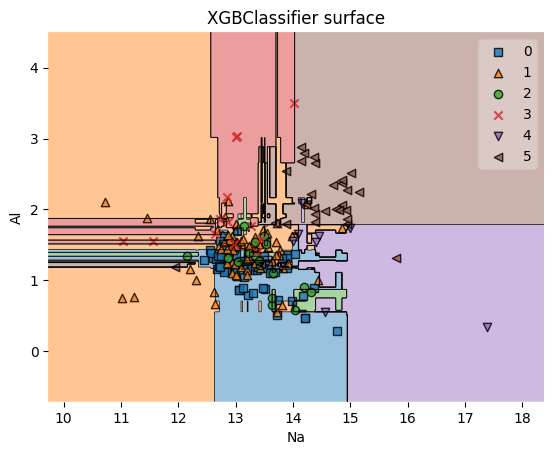

In [14]:
from xgboost import XGBClassifier, XGBRegressor

xgbc = XGBClassifier(seed=0)
xgbc.fit(X1_train, y1_train)
xgbc_pred_res = xgbc.predict(X1_test)
xgbc_accuracy = accuracy_score(y1_test, xgbc_pred_res)
print(f'xgbc accuracy: {xgbc_accuracy}')
print(xgbc_pred_res)

feature_indexes = [1, 3]
title2 = 'XGBClassifier surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, xgbc, feature_indexes, title2)

**XGBRegressor**

In [15]:
xgbr = XGBRegressor(seed=0)
xgbr.fit(X2_train, y2_train)
xgbr_pred_res = xgbr.predict(X2_test)
xgbr_mape = mean_absolute_percentage_error(y2_test, xgbr_pred_res)
print(f'xgbr mape: {xgbr_mape}')
print(xgbr_pred_res)

xgbr mape: 0.4341167858276216
[281.3304   241.21165  212.13124  136.89372  144.54208  261.7871
 125.257454 236.16089  199.79964  250.18103  188.50882  126.724464
 161.2112    73.98386  302.50272   97.35103  160.85774   67.10394
  96.0406   284.72873  181.48717  117.764626 182.91393  127.76686
 229.30229  173.58592  170.03932   76.73085  240.7698   117.70699
 224.36049   63.628925 124.27327  142.07358  173.09418  139.11557
 163.61208   92.8561    95.91142  217.65016  112.03522  122.800545
 110.06953  181.34201  159.39062   61.97588  114.534805 145.20259
  84.905815 284.77567  195.29976   45.550606  92.54941  180.4689
 279.12097  241.1343   177.77785  130.43887  159.53189  158.2313
 253.25339  181.86093  120.71679   90.604706 274.5059   140.21674
  92.80314  211.71936  233.20622  110.791824  67.89235  133.62137
 123.05923  102.70884  167.2115   159.32262  131.7305   243.41493
 254.97531  210.0554   130.00981  222.21094   52.864147 251.23187
 118.602684  87.89112  121.147095 218.15724   9

### **Преимущества и недостатки XGBoost**

Преимущества:
- относительно высокая скорость обучения и точность прогнозов;
- возможность работы с пропусками;
- гибкость в конфигурации из-за большого количества гиперпараметров.

Недостатки:
- сложность в конфигурации из-за большого количества гиперпараметров;
- на данный момент отсутствует полноценная (присутствует экспериментальная) возможность работы с категориальными признаками, что может сильно снизить производительность при кодировании больших объёмов данных.


### **Дополнительные источники**
Статья «XGBoost: A Scalable Tree Boosting System», Tianqi Chen, Carlos Guestrin.

[Документация](https://xgboost.readthedocs.io/en/stable/index.html).

Лекции:
- [один](https://www.youtube.com/watch?v=CCDIbNGGBwY&t=638s&ab_channel=ComputerScienceCenter);
- [два](https://www.youtube.com/watch?v=Vly8xGnNiWs&t=4168s&ab_channel=RealDataScienceUSA%28formerlyDataScience.LA%29).

Пошаговое построение XGBoost:
- [один](https://www.youtube.com/watch?v=OtD8wVaFm6E&list=PLZ5DHV9_5h9vQwAImmNi1RfoTtSuOUjwM&index=17&ab_channel=StatQuestwithJoshStarmer);
- [два](https://www.youtube.com/watch?v=8b1JEDvenQU&list=PLZ5DHV9_5h9vQwAImmNi1RfoTtSuOUjwM&index=17&ab_channel=StatQuestwithJoshStarmer);
- [три](https://www.youtube.com/watch?v=ZVFeW798-2I&list=PLZ5DHV9_5h9vQwAImmNi1RfoTtSuOUjwM&index=18&ab_channel=StatQuestwithJoshStarmer);
- [четыре](https://www.youtube.com/watch?v=oRrKeUCEbq8&list=PLZ5DHV9_5h9vQwAImmNi1RfoTtSuOUjwM&index=19&ab_channel=StatQuestwithJoshStarmer).

## **Особенности CatBoost**
CatBoost (Categorical Boosting) — более эффективная реализация градиентного бустинга от компании Яндекс, особенностью которой является возможность работы с категориальными признаками без их предварительной обработки. Разберёмся подробнее как это происходит.

### **Ordered target (CatBoost) encoding**
При кодировании категориальных признаков к бустингам применяется один из нескольких классических подходов:
- target encoding;
- one-hot encoding (хорошо работает лишь в том случае, когда в признаках содержится небольшое количество значений);
- feature hashing в несколько корзин (исходные данные преобразуются в уникальную последовательность символов (хэш-значения), которые разбиваются на группы (корзины) и обрабатываются параллельно с последующим применением target или one-hot encoding);
- mean target encoding (рассчитывается новое значение для текущего категориального признака как среднее значение целевой переменной по датасету);
- leave-one-out (рассчитывается среднее значение целевой переменной по всем объектам кроме текущего);
- leave-bucket-out (рассчитывается среднее значение целевой переменной на одной части данных и применяется для оставшихся других);

Однако все вышеперечисленные способы так или иначе приводят к утечке данных и переобучению, и данную проблему можно частично решить с применением *mean target encoding* на отложенной выборке, что работает заметно лучше, но такой способ не идеален так как остаётся меньше данных для обучения и вычисления статистик по категориальным признакам.

В CatBoost применяется модифицированный подход к mean target encoding, называемый *Ordered target (CatBoost) encoding*, который состоит из 3 нижеперечисленных этапов.

**Случайная перестановка**

Образцы в наборе данных перемешиваются случайным образом, что позволяет создать более сбалансированный набор данных и снизить переобучение.

**Статистики «по прошлому»**

После случайной перестановки рассчитывается новое значение для текущего категориального признака следующим образом: $$CTR = \frac{TargetSum + Prior}{TotalCount + 1}$$

$Prior$ — константа, определяемая как среднее арифметическое целевых значений.

$TargetSum$ — сумма целевых значений для конкретного категориального признака до текущего момента.

$TotalCount$ — количество всех наблюдений для конкретного категориального признака до текущего момента.

Данная формула применима как для регрессии, так и для мультиклассификации.


**Пошаговый пример с нуля для мультиклассификации**

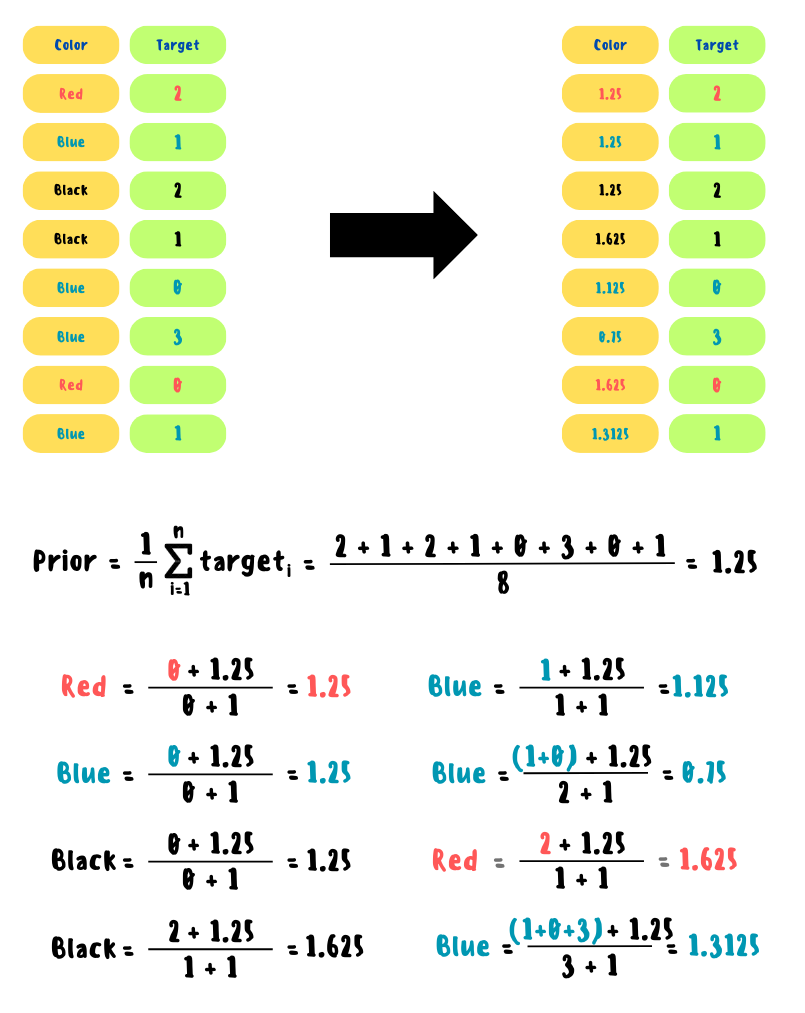

In [16]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.5 MB/s eta 0:00:00


In [17]:
from category_encoders.cat_boost import CatBoostEncoder

train = pd.DataFrame({"color": ["red", "blue", "black", "black", "blue", "blue", "red", "blue"]})
target = pd.Series([2, 1, 2, 1, 0, 3, 0, 1])

cbe_encoder = CatBoostEncoder()
train_cbe = cbe_encoder.fit_transform(train, target)
prior = target.mean()

print(f'prior: {prior}', '', sep='\n')
print(train_cbe)

prior: 1.25

    color
0  1.2500
1  1.2500
2  1.2500
3  1.6250
4  1.1250
5  0.7500
6  1.6250
7  1.3125


В случае с числовыми признаками создаётся набор меток с помощью квантования и производится их бинаризация на k классов: все значения до границы (метки) относятся к классу 0, а после к классу 1. Далее процедура схожа со случаем мультиклассификации.

В CatBoost поддерживаются следующие виды квантования:
- мода;
- медианная сетка;
- равномерная сетка + квантили (размер квантования уменьшается вдвое и разбиения (пороговые значения) объединяются по одному из двух способов: медиана или равномерная сетка);
- MaxLogSum — максимизируется значение следующего выражения внутри каждого сегмента:
$\sum\limits_{i=1}^{n} log \ w_i$
- MinEntropy — минимизируется значение следующего выражения внутри каждого сегмента:
$\sum\limits_{i=1}^{n} w_i \ log \ w_i$
- GreedyLogSum — максимизируется аппроксимация жадным способом следующего выражения внутри каждого сегмента:
$\sum\limits_{i=1}^{n} log \ w_i$

$\ \ \ \ $ где n — число различных объектов в сегменте, w (weight) — число повторений объекта в сегменте.

**Комбинация категориальных признаков**

В CatBoost используется комбинация категориальных признаков (например, красный диван, синий диван, синий стул и так далее), что позволяет модели учитывать неочевидные взаимосвязи между ними и улучшить качество итоговых прогнозов в целом. Для избегания экспоненциального роста комбинаций категориальных признаков, их создание происходит не перед началом обучения, а в момент построения каждого дерева жадным алгоритмом отдельно.

### **Структура решающих деревьев и упорядоченный бустинг**
В качестве базовых моделей в CatBoost используются симметричные односторонние деревья, имеющие одинаковую глубину и ширину. Создатели алгоритма считают, что такой подход позволяет ускорить обучение и создавать деревья, которые менее подвержены переобучению.

Для нахождения наилучшего критерия разбиения в узле используется косинусное сходство — его максимальное значение будет соответствовать лучшему критерию:

$$Cosine \ Similarity = \frac{ \sum\limits_{i=1}^{n} A_i B_i}{\sqrt{\sum\limits_{i=1}^{n} A_i^2}
\sqrt{\sum\limits_{i=1}^{n} B_i^2}}$$
где A — вектор с остаточными ошибками, B — вектор с прогнозами в листовых узлах.

Проблема классического бустинга заключается в том, что прогнозы базовых моделей могут иметь высокое смещение, что в конечном счёте приводит к переобучению модели в целом — это обусловлено тем, что обучение и оценка деревьев производится на одинаковом наборе данных (X_train). Данная проблема решается с помощью метода линейной аппроксимации упорядоченного бустинга (Ordered Boosting), суть которого заключается в следующем: данные перемешиваются случайным образом и после чего текущее дерево обучается на m-1 образцах с учётом остатков предыдущего, что очень похоже на принцип в ordered target encoding, то есть изначально берётся один образец из набора данных и модель учится на всех образцах до него, то есть на нулях, далее берётся два образца и модель учится на одном, после чего рассчитываются остатки, которые будут использованы для следующей модели и так далее. Такой подход позволяет произвести обучение дерева со сложностью O(log(m)) вместо O(m$^2$).

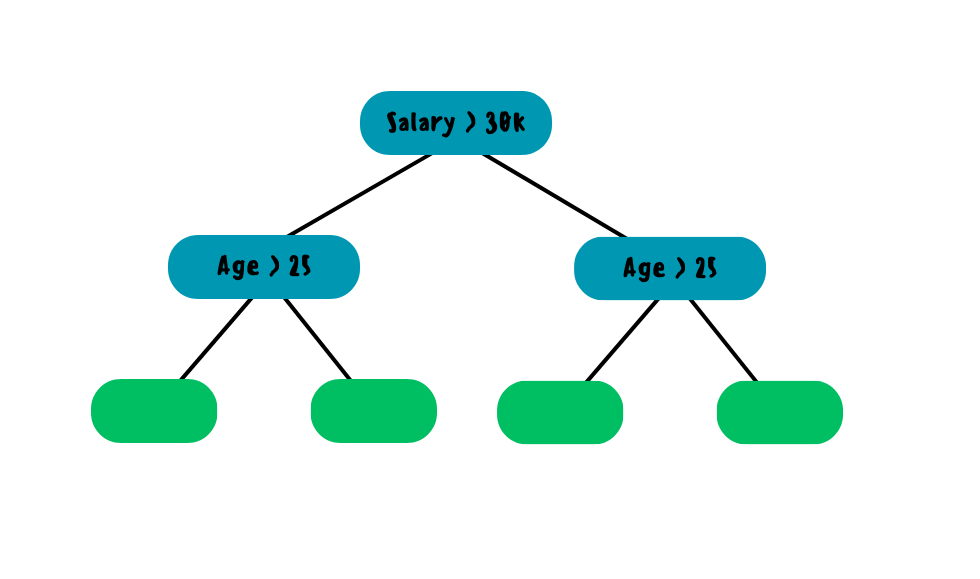

### **Дополнительные возможности CatBoost**
**Работа с пропусками**

Поддерживаются следующие режимы обработки пропусков:
- "Forbidden" — пропуски интерпретируются как ошибки.
- "Min" — пропуски обрабатываются как минимальное значение (меньшее, чем все остальные значения) для объекта.
- "Max" — пропуски обрабатываются как максимальное значение (превышающее все остальные значения) для объекта.

Режим обработки по умолчанию — Min. Также при выборе деревьев учитывается разбиение, отделяющее пропущенные значения от всех остальных.

**Snapshots**

Данный параметр (save_snapshot=True) позволяет создавать резервные копии промежуточных результатов. Если происходит неожиданное прерывание обучения (например, случайное выключение компьютера), то оно может быть продолжено из сохранённого состояния и в таком случае не нужно повторять завершённые итерации построения деревьев.

**Обучение на GPU**

В CatBoost возможно обучение не только на нескольких GPU, но и сразу на нескольких серверах с GPU, что фактически позволяет запустить распределённое обучение и использовать датасеты любого размера. Данная процедура позволяет значительно ускорить работу алгоритма: чем больше датасет, тем больше будет прирост в производительности в сравнении с обучением на CPU. Для того чтобы этим воспользоваться достаточно указать task_type="GPU".  







### **Пакетная реализация CatBoost и оценка полученных результатов**
Как можно заметить из примера классификации, не смотря на большое количество улучшений, CatBoost далеко не всегда показывает высокие результаты в сравнении с другими реализациями градиентного бустинга, как это заявляют его разработчики, особенно заметна разница в случае с несбалансированными наборами данных. Однако, стоит отметить, что в случае хорошей подготовки данных, при прочих равных, в ряде случаев CatBoost будет отличаться от других модификаций немного более высокой точностью.

В случае регрессии, когда нет явно выраженной проблемы как в случае выше, CatBoost справляется довольно хорошо.

Полученные результаты приведены ниже.

In [18]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.4 MB/s eta 0:00:00


**CatBoostClassifier**

cb_clf accuracy: 0.6851851851851852
[5 0 1 4 1 1 0 1 1 1 0 0 1 1 1 5 2 1 2 2 1 0 5 1 0 0 5 0 1 1 0 0 1 0 0 0 0
 0 0 5 1 5 1 0 1 1 0 1 0 1 0 1 5 0]


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


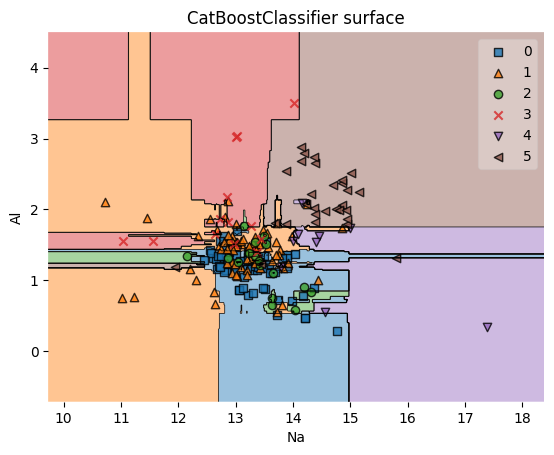

In [19]:
from catboost import CatBoostClassifier, CatBoostRegressor

cb_clf = CatBoostClassifier(random_seed=0, logging_level='Silent')
cb_clf.fit(X1_train, y1_train)
cb_clf_pred_res = cb_clf.predict(X1_test).squeeze()   # remove all single-dimensional entries
cb_clf_accuracy = accuracy_score(y1_test, cb_clf_pred_res)
print(f'cb_clf accuracy: {cb_clf_accuracy}')
print(cb_clf_pred_res)

feature_indexes = [1, 3]
title3 = 'CatBoostClassifier surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, cb_clf, feature_indexes, title3)

**CatBoostRegressor**

In [20]:
cb_reg = CatBoostRegressor(random_seed=0, logging_level='Silent')
cb_reg.fit(X2_train, y2_train)
cb_reg_pred_res = cb_reg.predict(X2_test)
cb_reg_mape = mean_absolute_percentage_error(y2_test, cb_reg_pred_res)
print(f'cb_reg mape: {cb_reg_mape}')
print(cb_reg_pred_res)

cb_reg mape: 0.39538306365546094
[268.21698587 226.61112865 152.56164473 105.39534082 185.56084388
 231.13386917 112.94031582 246.11217136 121.83631454 238.66069067
 193.92810529 171.53207065 120.95427566  98.87431921 301.0159263
  97.989809   170.68360243  70.03044356 104.9534818  235.1624283
 174.7895105  131.39173163 178.28683674 128.13631321 230.60611298
 186.37090017 131.52230822  61.453026   231.95028492 148.67901568
 186.2317954   80.45908918 137.68617262 171.24445717 128.77648933
 178.31364898 179.17236177 149.82094832 102.25676058 209.48231728
 116.01443961 169.06621701 110.9047463  210.24240477 158.28102362
  72.4532758  135.86931928 121.14865532  76.8103627  278.66222581
 127.85077736  55.25704176 144.51194393 170.06468442 271.51905928
 187.61879537 159.56680649 118.65520621 121.92004997 183.56316238
 248.87847858 137.77180529 117.98743897  82.53109543 255.59388802
 151.23062005  94.00606836 257.15481144 227.21705762  96.77322241
  78.34198817 118.09701594  91.2069645   91.7

### **Преимущества и недостатки CatBoost**
Преимущества:
- высокая точность и скорость обучения в большинстве случаев;
- возможность работы с категориальными признаками;
- большое количество гиперпараметров для настройки алгоритма;
- применяется для многих задач.

Недостатки:
- нестабильная работа с несбалансированными данными;
- сложность в конфигурации из-за большого количества гиперпараметров;
- плохая документация (личное мнение).


### **Дополнительные источники**
Статья «CatBoost: unbiased boosting with categorical features», Liudmila Prokhorenkova, Gleb Gusev, Aleksandr Vorobev, Anna Veronika Dorogush, Andrey Gulin.

[Документация](https://catboost.ai/en/docs/).

[Лекция](https://www.youtube.com/watch?v=UYDwhuyWYSo&t=1281s&ab_channel=ComputerScienceCenter).

Пошаговое построение CatBoost (в ordered target encoding есть ошибки):
- [один](https://www.youtube.com/watch?v=KXOTSkPL2X4&t=447s&ab_channel=StatQuestwithJoshStarmer);
- [два](https://www.youtube.com/watch?v=3Bg2XRFOTzg&ab_channel=StatQuestwithJoshStarmer).


# **Особенности LightGBM**
LightGBM (Light Gradient Boosting Machine) — реализация градиентного бустинга от компании Microsoft, способная обрабатывать большие наборы данных и при этом обеспечивать высокую точность. Рассмотрим более подробно ключевые особенности, которые на это повлияли.  

### **Gradient-based One-Side Sampling (GOSS)**
В отличие от классического градиентного бустинга, где регрессионные деревья обучаются на всём множестве X_train, в LightGBM деревья обучаются на подмножестве данных, полученном с помощью одностороннего отбора на основе градиента (GOSS), суть которого заключается в сортировке и выборе образцов top N с наибольшим градиентом — это означает, что именно этим данным следует уделить особое внимание, поскольку на них дерево будет ошибаться больше всего. Помимо этого, случайным образом производится отбор части образцов с низким градиентом с последующим присвоением им весов $\frac{1-a}{b}$, чтобы избежать изменений в распределении данных.

$a$ — доля образцов top N в процентах с наибольшим градиентом, $b$ — доля образцов в процентах с низким градиентом.

Проще говоря, использование GOSS позволяет значительно ускорить обучение каждого последующего дерева в ансамбле путём уменьшения обучающего набора данных без особой потери в качестве прогнозов в большинстве случаев.

### **Histogram-based tree node splitting**
При поиске наилучшего критерия разбиения узла в LightGBM также можно использовать гистограмму значений признаков: перебираются все пороговые значения гистограммы вместо всех значений признаков, что позволяет существенно ускорить поиск наилучшего критерия. Например, для признака "рост" можно использовать вопросы "рост" ⩽ 160, "рост" ⩽ 170 вместо "рост" ⩽ 163, "рост" ⩽ 167 и так далее.
Как можно было заметить, гистограммы применяются в том или ином виде во всех трёх модификациях градиентного бустинга.

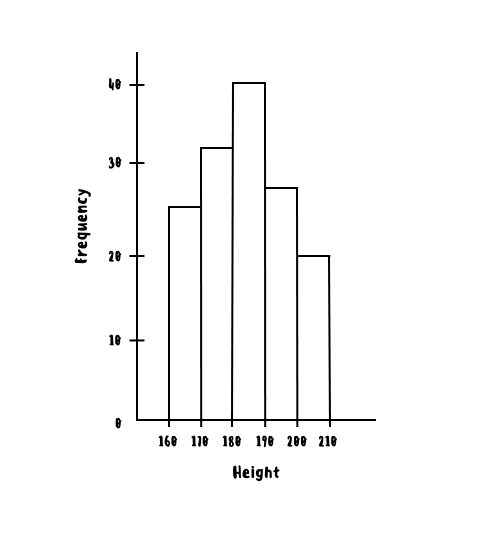

### **Exclusive Feature Bundling (EFB)**
Предположим, что тем или иным образом в датасете имеются закодированные категориальные признаки, большинство из которых являются взаимоисключающими (те, которые одновременно не принимают ненулевые значения). При большом числе таких признаков обучение модели может занять слишком много времени и для решения данной проблемы в LightGBM применяется понижение размерности пространства признаков путём объединения взаимоисключающих признаков (EFB).

Стоит отметить, что в действительности строго взаимоисключающие признаки в данных встречаются крайне редко. Поэтому вводится  такое понятие как доля конфликтов между признаками — отношение наблюдений от общего числа, где два признака принимают одновременно ненулевые значения.

Допустим, имеется датасет с признаками $F_0 - F_4$. В первую очередь стоит установить допустимую долю конфликтов, например, 25%. Тогда в случае из 8 образцов допустимое число конфликтов будет составлять 2. Далее строится матрица конфликтов между всеми признаками и производится подсчёт общей суммы конфликтов для каждого признака, после чего происходит их сортировка в порядке убывания.

На основе матрицы конфликтов строится взвешенный граф, у которого в полученном порядке отсекаются все рёбра с числом конфликтов, превышающим допустимое значение.

**Работа Exclusive Feature Bundling с нуля на простом примере**

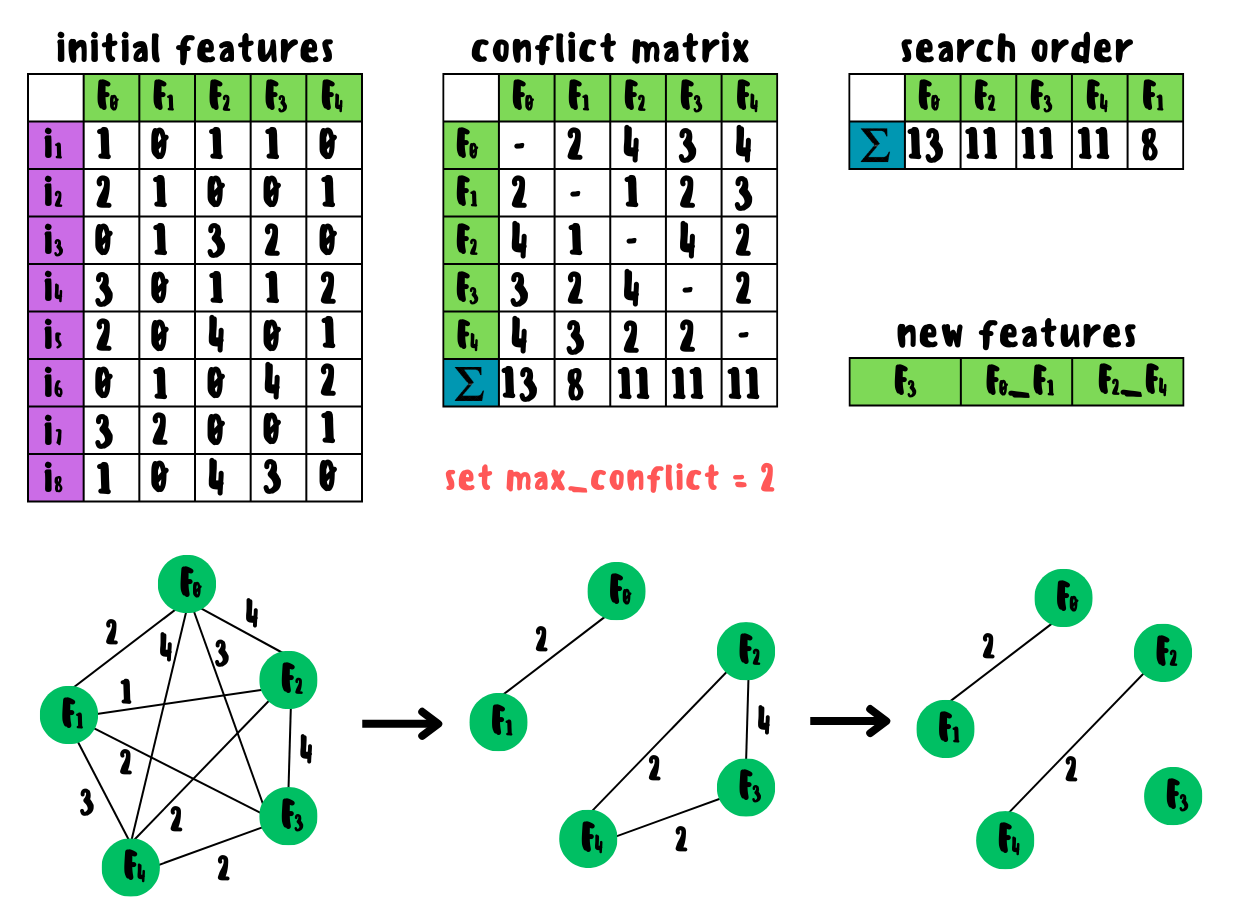

Первой связкой будет $F_0 - F_1$. Не смотря на то что $F_1 - F_2$ и $F_1 - F_3$ не конфликтуют, их объединение невозможно из-за конфликтов $F_0 - F_2$ и $F_0 - F_3$. Следующей связкой будет $F_2 - F_4$. Не смотря на то, что $F_4$ и $F_3$ не конфликтуют, их объединение невозможно из-за конфликта $F_2 - F_3$. Последним остаётся признак $F_3$.

Новая связка будет состоять из ненулевых значений первого признака и ненулевых значений второго плюс смещение, равное максимальному значению первого признака: смещение каждого следующего признака будет равно сумме максимальных значений предыдущих. В случаях, когда наблюдается конфликт, берётся значение последнего признака со смещением.


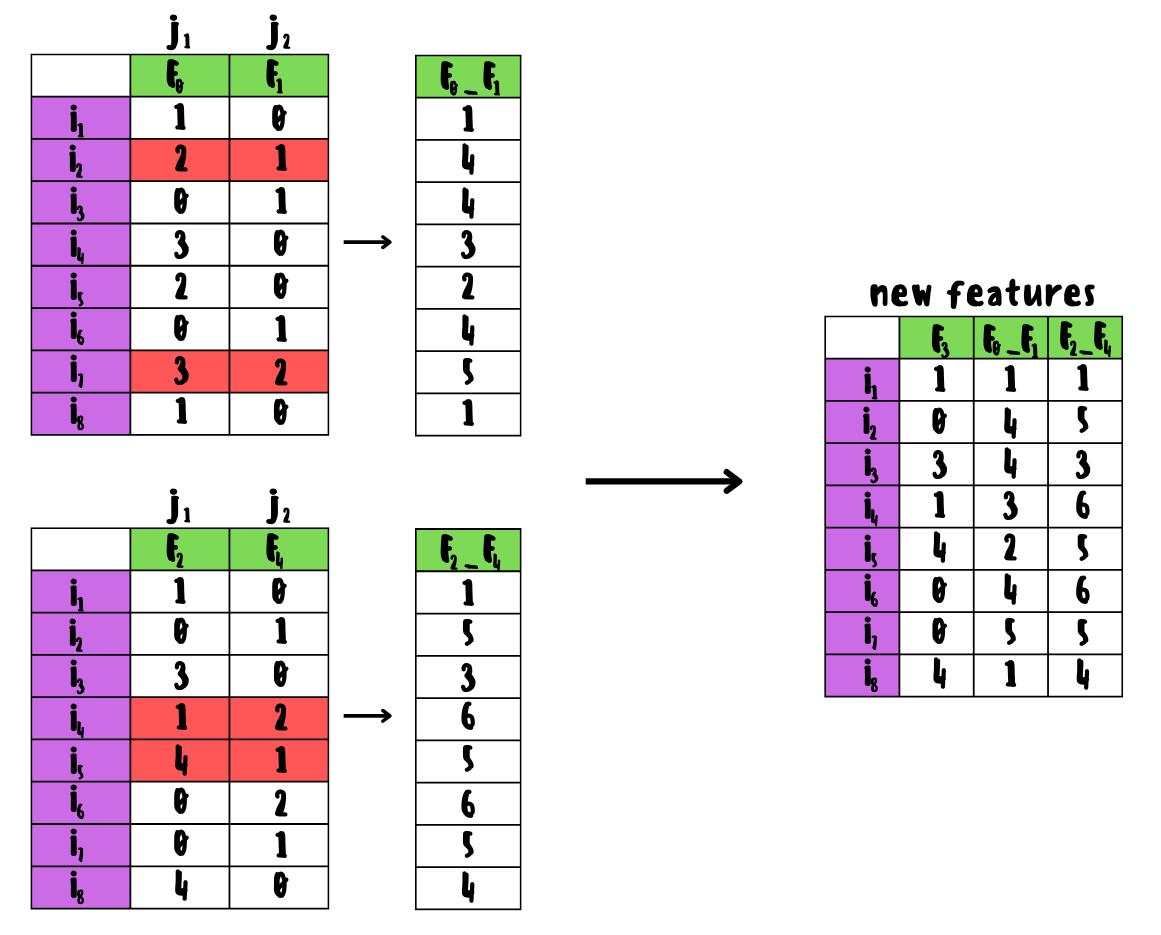

Подробные расчёты приведены ниже.

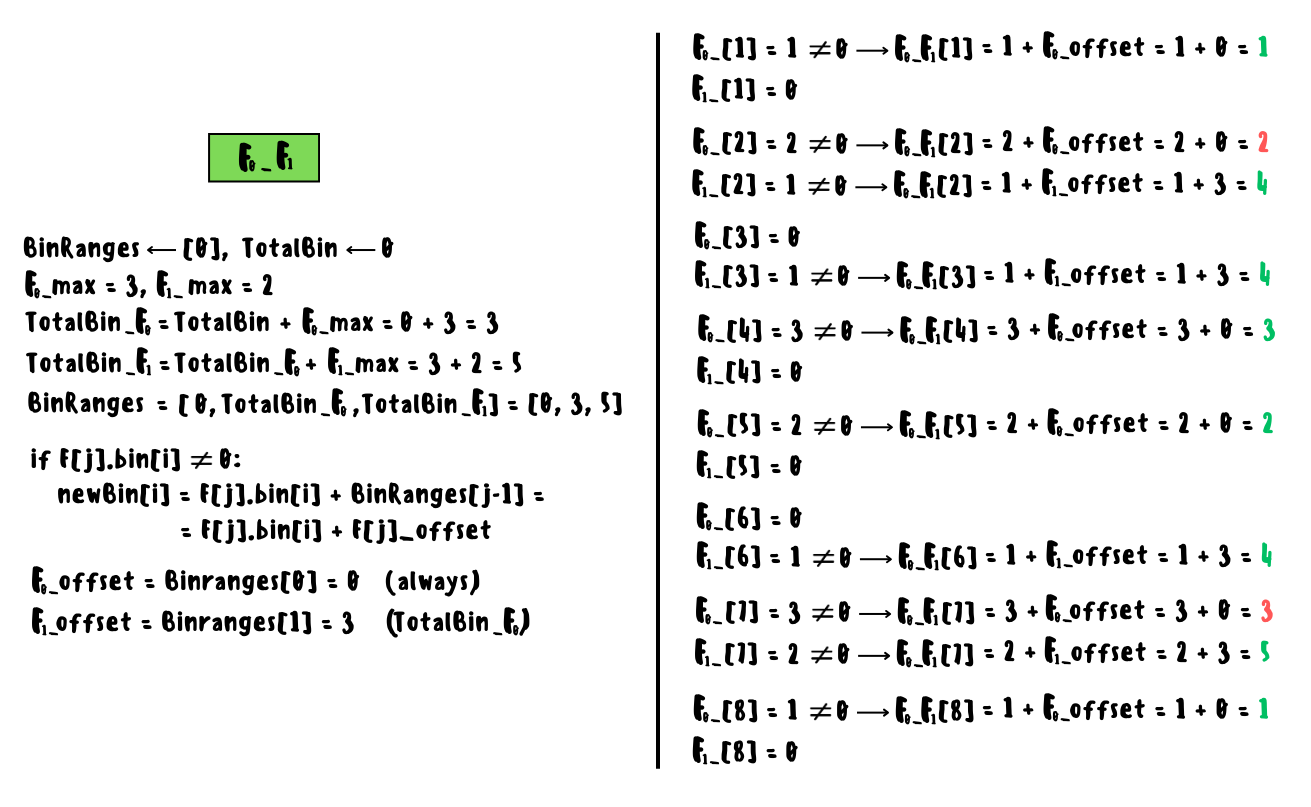

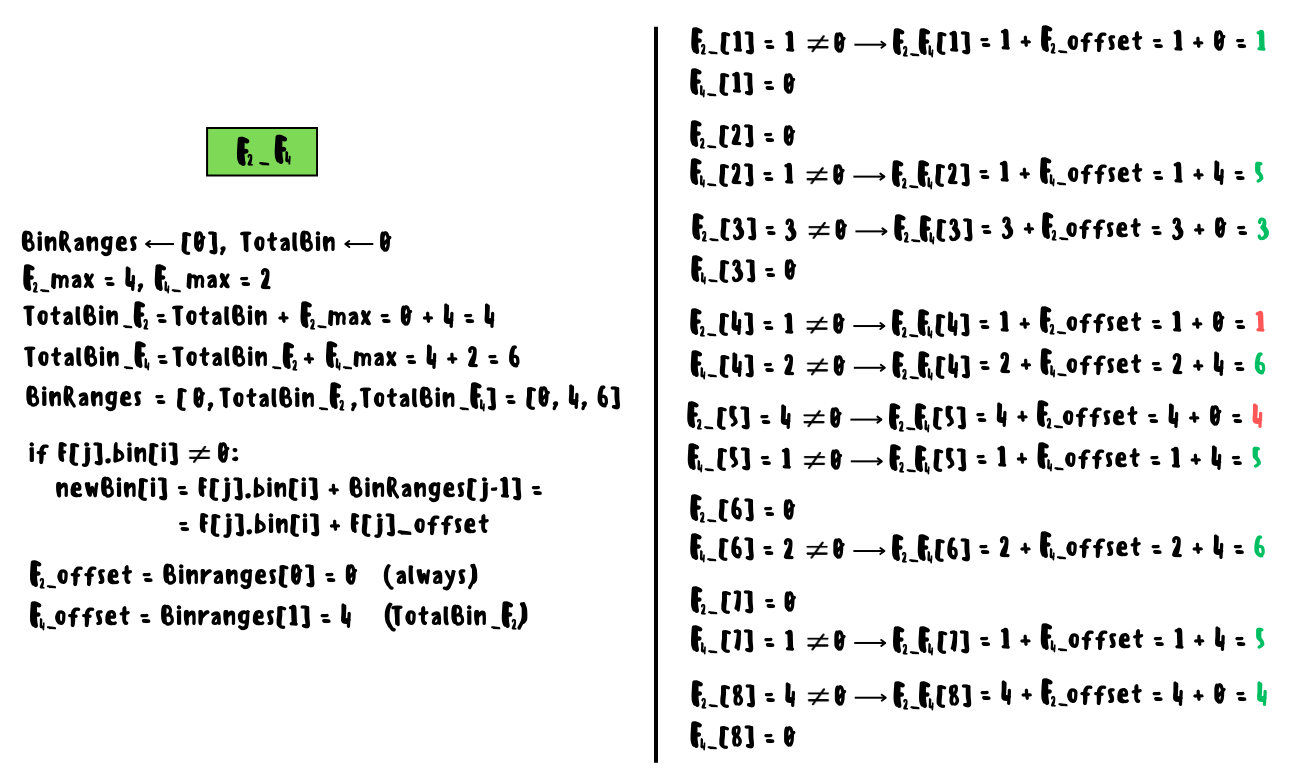

Нетрудно заметить, что алгоритм EFB можно оптимизировать, игнорируя вычисления для всех нулевых значений в признаках. Также данную оптимизацию можно применить к *histogram-based tree node splitting*, что в целом снизит сложность построения гистограммы с O(data) до O(non-zero data).

### **Leaf-wise tree growth**
Вместо построения деревьев слой за слоем, в LightGBM деревья строятся в глубину: рост продолжается в листовом узле с наибольшим информационным приростом, в результате чего дерево получается глубоким и несимметричным. Чаще всего такой подход превосходит симметричные деревья в плане точности.



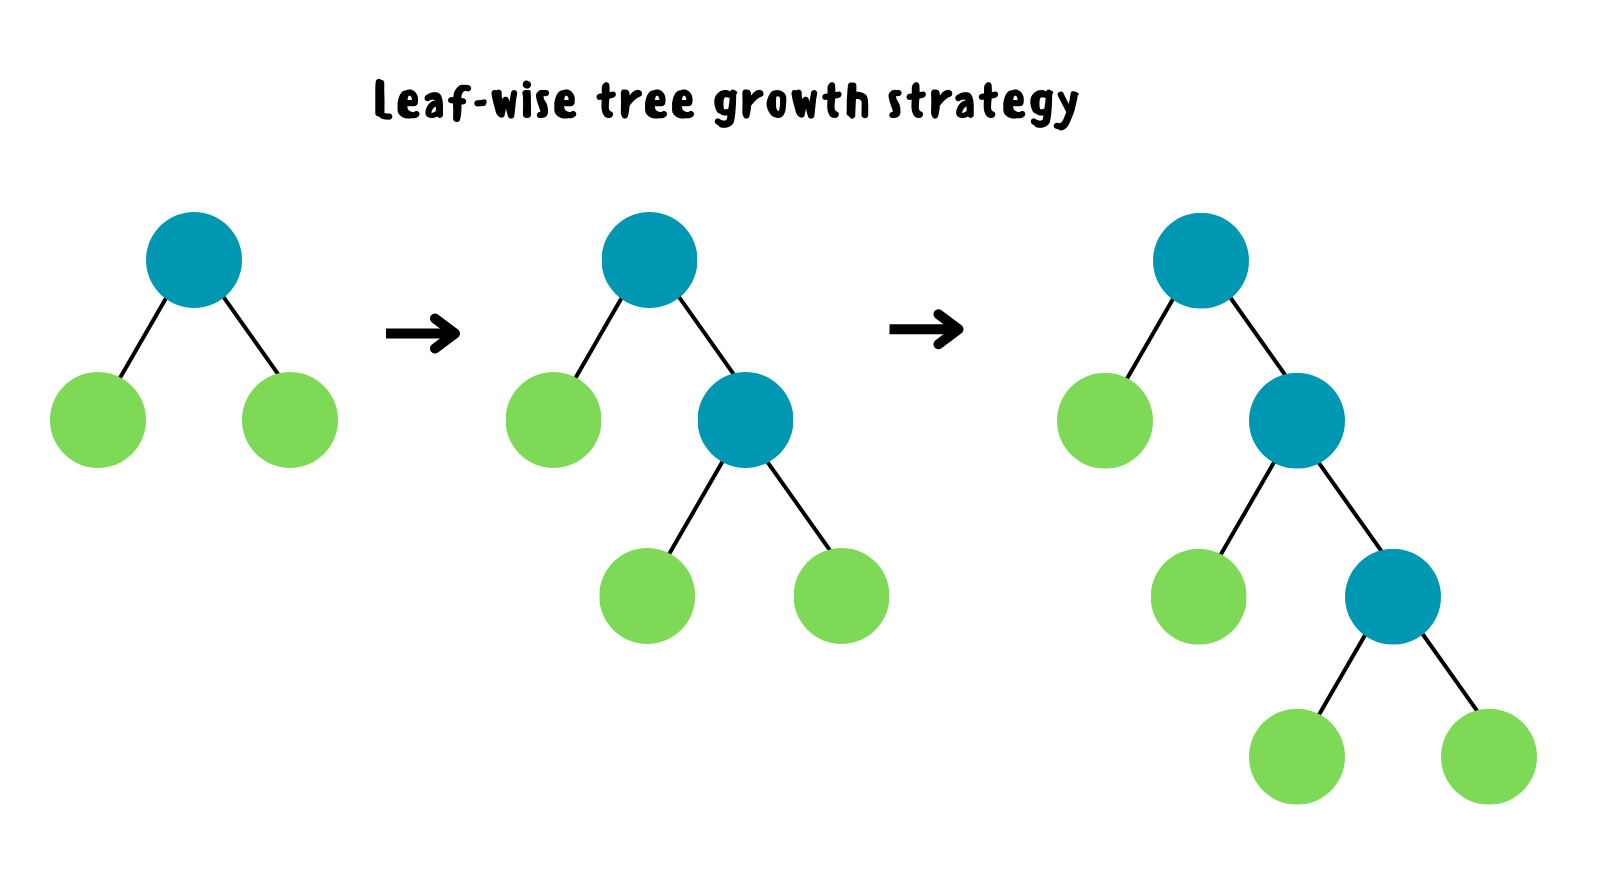

### **Обучение на GPU**
При работе с большими датасетами в LightGBM поддерживается обучение не только на GPU, но и распределённое обучение сразу на нескольких машинах.

На данный момент существуют следующие подходы:

- Data parallel (образцы датасета разбиваются на локальные гистограммы, каждая из которых обрабатывается отдельно);
- Feature parallel (признаки датасета разбиваются на локальные гистограммы, каждая из которых обрабатывается отдельно);
- Voting parallel (на каждом процессе локально выбирается K лучших признаков для разбиения, после чего выбирается наилучший из них глобально).

### **Пакетная реализация LightGBM и оценка полученных результатов**
Как можно заметить, в случае классификации LightGBM показал результат из коробки значительно лучше, чем предыдущие модификации бустинга. Также стоит отметить, что из всех трёх рассмотренных модификацией градиентного бустинга LightGBM является самой быстрой: чем больше датасет, тем сильнее будет заметна разница в плане скорости.

Полученные результаты приведены ниже.

**LGBMClassifier**

lgb_clf accuracy: 0.7407407407407407
[5 0 1 4 1 1 0 1 1 1 0 0 0 1 1 5 2 1 2 2 3 1 5 5 0 0 5 0 1 1 0 0 1 0 0 0 0
 0 0 5 1 4 1 0 0 1 0 1 0 1 0 1 5 0]


/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


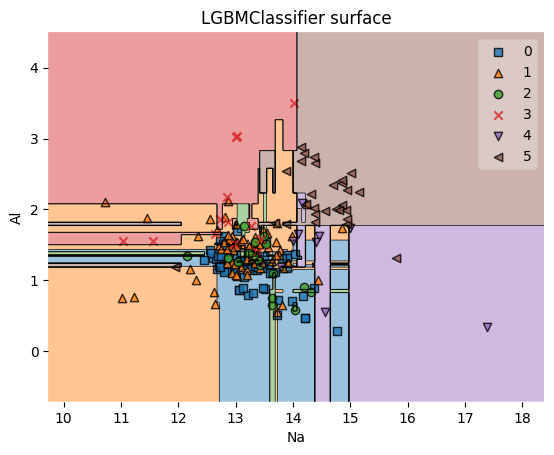

In [21]:
from lightgbm import LGBMClassifier, LGBMRegressor

lgb_clf = LGBMClassifier(random_state=0, verbose=-1)
lgb_clf.fit(X1_train, y1_train)
lgb_clf_pred_res = lgb_clf.predict(X1_test)
lgb_clf_accuracy = accuracy_score(y1_test, lgb_clf_pred_res)
print(f'lgb_clf accuracy: {lgb_clf_accuracy}')
print(lgb_clf_pred_res)

feature_indexes = [1, 3]
title4 = 'LGBMClassifier surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, lgb_clf, feature_indexes, title4)

**LGBMRegressor**

In [22]:
lgb_reg = LGBMRegressor(random_state=0, verbose=-1)
lgb_reg.fit(X2_train, y2_train)
lgb_reg_pred_res = lgb_reg.predict(X2_test)
lgb_reg_mape = mean_absolute_percentage_error(y2_test, lgb_reg_pred_res)
print(f'lgb_reg_mape: {lgb_reg_mape}')
print(lgb_reg_pred_res)

lgb_reg_mape: 0.39864113147931
[261.46864967 223.24674049 179.60231224 104.76984808 197.67529058
 264.26116883 111.11355079 243.72059654 144.18045853 239.08131542
 199.90841705 170.37417433 151.67933516  89.30779664 297.93561211
  96.58862229 162.53285879  70.06113305 108.36436227 234.16276627
 207.7552967  136.83913826 172.38724529 110.26981866 228.1574526
 163.56817258 108.94516511  73.93303203 233.31869769 116.00042252
 195.39846082  72.54403358 164.38943926 194.42418913 130.42154381
 183.04435501 173.56352142 147.00774306  89.07365731 175.25759644
 108.72749406 144.48000593  99.60713604 196.86889512 160.47835096
  60.17798032 133.4909559  115.46543242  64.48286456 251.20520649
 135.52608509  45.16396653 161.70420785 187.28406745 274.21158331
 179.30355071 150.1563969  111.1275583  100.5067047  133.7868607
 269.98464504 159.03980859 118.01578638  75.41625416 249.0569831
 133.99026562 111.43954756 221.81954307 206.02676942  81.56098377
  72.5920367  101.31664062  93.31261471 111.2448

### **Преимущества и недостатки LightGBM**
Преимущества:
- высокая точность прогнозов и особенно скорость обучения;
- возможность работы с категориальными признаками;
- большое количество гиперпараметров для настройки алгоритма;
- применяется для многих задач.

Недостатки:
- возможна нестабильная работа на датасетах небольшого размера;
- сложность в конфигурации из-за большого количества гиперпараметров.


### **Дополнительные источники**
Статья «LightGBM: A Highly Efficient Gradient Boosting Decision Tree», Guolin Ke, Qi Meng, Thomas Finley, Taifeng Wang, Wei Chen, Weidong Ma, Qiwei Ye, Tie-Yan Liu.

[Документация](https://lightgbm.readthedocs.io/en/latest/index.html).

Лекции:
- [один](https://www.youtube.com/watch?v=NH0ozgXjrzk&t=304s&ab_channel=%D0%A6%D0%B5%D0%BD%D1%82%D1%80digital%D0%BF%D1%80%D0%BE%D1%84%D0%B5%D1%81%D1%81%D0%B8%D0%B9ITtensive);
- [два](https://www.youtube.com/watch?v=qGsHlvE8KZM&ab_channel=PyData);
- [три](https://www.youtube.com/watch?v=E1-FFzKuDgY&list=PLgaemU2xZlTgJhfBHnolmS-8WwsFifnFn&index=2&ab_channel=meanxai);
- [четыре](https://www.youtube.com/watch?v=fU_X_c1W3r4&list=PLgaemU2xZlTgJhfBHnolmS-8WwsFifnFn&index=1&ab_channel=meanxai).

## **Какой бустинг лучше**
Однозначного ответа на вопрос какой бустинг лучше нет. Если раньше можно было сказать, что при работе с категориальными признаками лучше использовать CatBoost, когда важна скорость — LightGBM, ну или XGBoost, если хочется стабильное решение и нет времени на эксперименты, то сейчас такое утверждение будет неверным: как можно было заметить, все три модификации успели скопировать друг у друга много хороших идей, но исторически они отличались довольно сильно.

Более правильным будет утверждение, что выбор наилучшего бустинга будет зависеть от конкретной задачи и данных, которые применяются для обучения модели: в разных сценариях одни и те же алгоритмы могут показывать как лучшие результаты в плане скорости и точности, так и наоборот — худшие. Таким образом, выбор наиболее оптимального бустинга будет заключаться в проведении экспериментов с разными модификациями и сравнении полученных результатов.


### **Несколько полезных источников со сравнением бустингов**
[Один](https://neptune.ai/blog/when-to-choose-catboost-over-xgboost-or-lightgbm), [два](https://www.kaggle.com/code/faressayah/xgboost-vs-lightgbm-vs-catboost-vs-adaboost), [три](https://medium.com/riskified-technology/xgboost-lightgbm-or-catboost-which-boosting-algorithm-should-i-use-e7fda7bb36bc).